Homemade example of profile likelihood method with 1 background and 1 shape nuisance. Complete details in
https://arxiv.org/pdf/1503.07622.pdf and https://arxiv.org/pdf/1007.1727.pdf

In [9]:
%matplotlib inline

import os
import sys
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats


In [10]:
mpl.rcParams["font.family"] = "sans-serif"
mpl.rcParams["font.sans-serif"] = ["Helvetica", "Arial", "Liberation Sans", "Bitstream Vera Sans", "DejaVu Sans"]
mpl.rcParams['legend.fontsize'] = 11
mpl.rcParams['legend.labelspacing'] = 0.2
mpl.rcParams['hatch.linewidth'] = 0.5
mpl.rcParams['axes.xmargin'] = 0.0 # rootlike, no extra padding within x axis
mpl.rcParams['axes.labelsize'] = 'x-large'
mpl.rcParams['axes.formatter.use_mathtext'] = True
mpl.rcParams['legend.framealpha'] = 0.65
mpl.rcParams['axes.labelsize'] = 'x-large'
mpl.rcParams['axes.titlesize'] = 'large'
mpl.rcParams['xtick.labelsize'] = 'large'
mpl.rcParams['ytick.labelsize'] = 'large'
mpl.rcParams['figure.subplot.hspace'] = 0.1
mpl.rcParams['figure.subplot.wspace'] = 0.1
mpl.rcParams['figure.subplot.right'] = 0.96
mpl.rcParams['figure.max_open_warning'] = 0
mpl.rcParams['figure.dpi'] = 125
mpl.rcParams["axes.formatter.limits"] = [-5,4] # scientific notation if log(y) outside this

os.system("mkdir -p plots/")

0

Fake data with a single background and a single signal as a function of number of jets. The background has a shape variation, which prefers to increase yields at higher number of jets.

In [11]:
include_syst = True
stack_signal = False

bin_edges = np.array([-0.5,0.5,1.5,2.5,3.5])
bin_centers = 0.5*(bin_edges[1:]+bin_edges[:-1])
v_data = np.array([34,22,13,11])
v_sig = np.array([2.,3.,4.,5.])
v_bg = np.array([30.0,19.,9.,4.])
if include_syst: f = 1.
else: f = 0.
var = np.array([0.0,0.5,1,1])
v_bg_up = v_bg + f*var
v_bg_down = v_bg - f*var

In [12]:
def poisson_errors(obs,alpha=1-0.6827):
    """
    Return Clopper-Pearson poisson low and high values for a series of data observations
    """
    from scipy.stats import gamma
    lows = np.nan_to_num(gamma.ppf(alpha/2,np.array(obs)))
    highs = np.nan_to_num(gamma.ppf(1.-alpha/2,np.array(obs)+1))
    return lows, highs

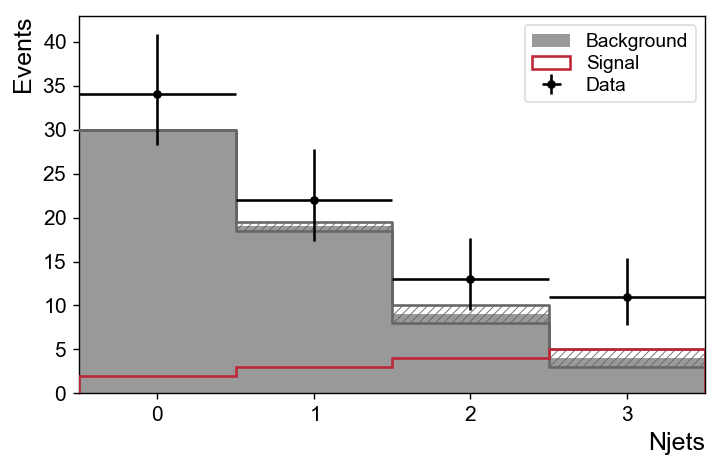

In [13]:

fig, ax_main = plt.subplots()

if stack_signal:
    ax_main.hist(
            [bin_centers,bin_centers],
            bins=bin_edges,
            weights=[v_bg,v_sig],
            label=["Background","Signal"],
            color=[[0.60,0.60,0.60],[0.75,0.15,0.22]],
            histtype= "stepfilled",
            stacked= True,
            )
else:
    ax_main.hist(
            [bin_centers],
            bins=bin_edges,
            weights=[v_bg],
            label=["Background"],
            color=[[0.60,0.60,0.60]],
            histtype= "stepfilled",
            )
    ax_main.hist(
            [bin_centers],
            bins=bin_edges,
            weights=[v_sig],
            label=["Signal"],
            color=[[0.75,0.15,0.22]],
            histtype= "step",
            linewidth=1.5,
            zorder=20,
            )

double_edges = np.repeat(bin_edges,2,axis=0)[1:-1]
his = np.repeat(v_bg_up,2)
los = np.repeat(v_bg_down,2)
ax_main.fill_between(double_edges,his,los, step="mid",
    hatch="/////", facecolor="none",
    edgecolor=(0.4,0.4,0.4), linewidth=1.5, linestyle='-',
    zorder=4,
    )

data_low, data_high = poisson_errors(v_data)
ax_main.errorbar(
        bin_centers,
        v_data,
        yerr = (v_data-data_low, data_high-v_data),
        xerr = np.ones(4)*0.5,
        label="Data",
        color="k",
        linestyle="",
        marker="o",
        markersize=4,
        linewidth=1.5,
        zorder=100,
        )

ax_main.legend()
ax_main.set_xticks([0,1,2,3])
ax_main.set_xlabel("Njets",horizontalalignment="right",x=1.)
_ = ax_main.set_ylabel("Events",horizontalalignment="right",y=1.)
fig.savefig("plots/njets.pdf")

Make a function that interpolates between up and down systematic templates for the background.

In [14]:
def interpolate_template(central,up,down,f=0.,linear=False):
    """
    Takes 3 templates and an interpolation factor f
    f=-1,0,1 returns the down,central,up variation template
    """
    if linear:
        if f>0.: 
            return np.clip(f*(up-central)+central,0.,None)
        else: 
            return np.clip(f*(central-down)+central,0.,None)
    else:
        if f>0.: 
            return central*((up/central)**f)
        else: 
            return np.clip(central*((down/central)**(-f)),0.,None)

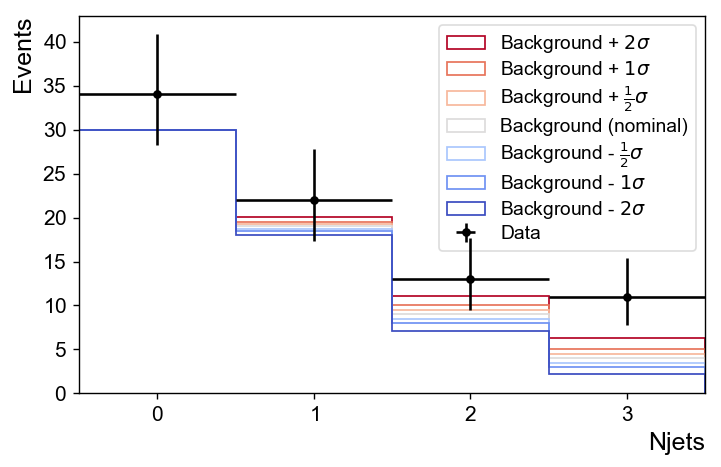

In [15]:
fig, ax_main = plt.subplots()

from matplotlib import cm
ax_main.hist(
        [bin_centers]*7,
        bins=bin_edges,
        weights=[
                interpolate_template(v_bg,v_bg_up,v_bg_down,-2.),
                interpolate_template(v_bg,v_bg_up,v_bg_down,-1.),
                interpolate_template(v_bg,v_bg_up,v_bg_down,-0.5),
                v_bg,
                interpolate_template(v_bg,v_bg_up,v_bg_down,0.5),
                interpolate_template(v_bg,v_bg_up,v_bg_down,1.),
                interpolate_template(v_bg,v_bg_up,v_bg_down,2.),
                ],
        label=[
            r"Background - $2\sigma$",
            r"Background - $1\sigma$",
            r"Background - $\frac{1}{2}\sigma$",
            r"Background (nominal)",
            r"Background + $\frac{1}{2}\sigma$",
            r"Background + $1\sigma$",
            r"Background + $2\sigma$",
        ],
        color = map(cm.coolwarm,np.linspace(0.,1.,7)),
        histtype= "step",
        )

data_low, data_high = poisson_errors(v_data)
ax_main.errorbar(
        bin_centers,
        v_data,
        yerr = (v_data-data_low, data_high-v_data),
        xerr = np.ones(4)*0.5,
        label="Data",
        color="k",
        linestyle="",
        marker="o",
        markersize=4,
        linewidth=1.5,
        zorder=100,
        )

ax_main.legend()
ax_main.set_xticks([0,1,2,3])
ax_main.set_xlabel("Njets",horizontalalignment="right",x=1.)
_ = ax_main.set_ylabel("Events",horizontalalignment="right",y=1.)
fig.savefig("plots/backgroundvariations.pdf")

We want to compute the likelihood which will be a 2D function of the signal strength $\mu$ and the value of the systematic variation $\theta$. $\theta=0$ will give the normal background yields, while $\theta=-1$ and $\theta=1$ will give the $1\sigma$ down and up variations, respectively. Note that from above, $\theta=1$ will "eat up" the signal, as it increases the background yield at high number of jets.

The likelihood function is the binned probability to get the data from a b or s+b poisson distribution, accounting for the pdf probability of nuisances $\theta$.
$$
\mathcal{L}(\mathrm{data}|\mu,\theta)=\prod_{j\in\mathrm{bins}}
\frac{(\mu s_j + b_j)^{n_j}}{n_j!}
e^{-(\mu s_j + b_j)}
p(\theta)
$$
where $n_j$ represents the data count in bin $j$, $b_j$ the background count, and $s_j$ the signal count. Technically, $b_j$ is a function of $\theta$; that is, $b_j(\theta)$ depends on the value of the systematic variation where $b_j(0)$ is the nominal background yield.

The goal is find maxima in the likelihood scan. Numbers can get very large given the factorial and the exponential. Since the $\ln$ function is monotonically increasing, to make things numerically tractable and simpler, take the log. Actually, the negative logarithm since minimization problems are easier than maximization. In our case, we don't really need the negative sign, but we do it anyway.
$$
-\ln\mathcal{L}=-\sum_{j=0}^{3}\left[
n_j \ln(\mu s_j + b_j) - \ln(n_j!) - (\mu s_j + b_j) + \ln(p(\theta))
\right]
$$

Even though it won't matter in the end (since we ultimately care about relative differences in the likelihood) note that $\ln(n_j!)$ is just $\sum_{i=0}^{3}\ln(i)$ and it is independent of $\mu$ and $\theta$, so it can be pre-computed.

In [16]:
def log_factorial(x):
    """
    Returns ln(x!) = ln(1) + ln(2) + ... + ln(x)
    """
    return np.sum(np.log(np.arange(int(x))+1))

# Make the values of mu, theta that we want to scan over
all_mus = np.linspace(0.,3.,155.)
all_thetas = np.linspace(-2.,3.,156.)

# Make a Gaussian(0,1) PDF to sample the theta values from
norm = scipy.stats.norm(0,1)
all_pthetas = norm.pdf(np.abs(all_thetas))

# Precompute the ln(N!) terms for data in each bin
n_logfac = np.array(map(log_factorial,v_data))

# Where we will store triplets of (mu,theta,NLL)
vals = []


# Store a list of the theta giving highest log_likelihood for a given mu
# as well as the negative log likelihood value using that theta
all_best_thetas = []
all_best_nlls = []
for mu in all_mus:
    mu_thetas = [] # keep track of the thetas and nlls for this mu, then take the maximum for all_best_thetas later
    mu_nlls = [] #
    for theta,ptheta in zip(all_thetas,all_pthetas):

        bg = interpolate_template(v_bg,v_bg_up,v_bg_down,f=theta)
        sig = 1.0*v_sig
        n = 1.0*v_data
        k = mu*sig + bg

        log_likelihood = np.sum(n*np.log(k) - n_logfac - k + np.log(ptheta))
        nll = -log_likelihood

        vals.append([mu,theta,nll])
        mu_thetas.append(theta)
        mu_nlls.append(nll)

    mu_thetas = np.array(mu_thetas)
    mu_nlls = np.array(mu_nlls)
    all_best_thetas.append(mu_thetas[mu_nlls.argmin()])
    all_best_nlls.append(mu_nlls.min())

all_best_thetas = np.array(all_best_thetas)
all_best_nlls = np.array(all_best_nlls)

# Drop nan likelihood values
vals = np.array(vals)
vals = vals[np.isfinite(vals[:,2])]



/Library/Python/2.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  
/Library/Python/2.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  if __name__ == '__main__':



We now have likelihood values over the $\mu$-$\theta$ plane. Let's plot contours as well as the maximum log likelihood (or in our case, the minimum *negative* log likelihood) globally (will be shown as a cross), and also as a function of the value of $\mu$ (will be shown as a red line). These will be important in subsequent steps.

/Library/Python/2.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.


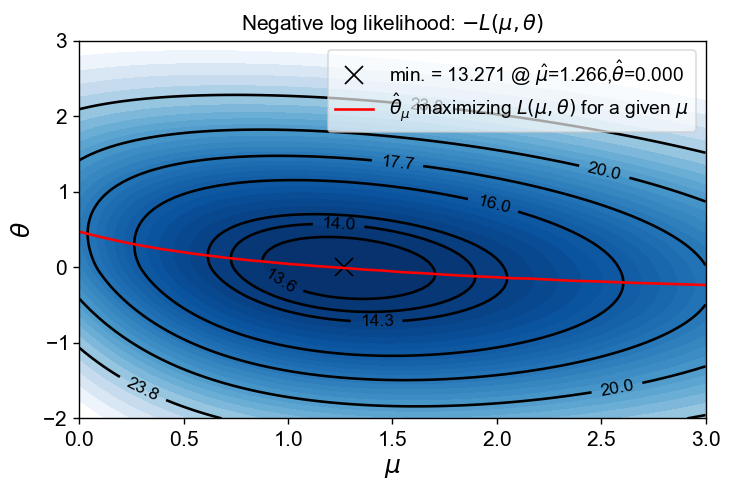

In [17]:
def grid(x, y, z, resX=100, resY=100):
    # stolen from stackoverflow
    from numpy import linspace, meshgrid
    from matplotlib.mlab import griddata
    xi = linspace(min(x), max(x), resX)
    yi = linspace(min(y), max(y), resY)
    Z = griddata(x, y, z, xi, yi, interp="linear")
    X, Y = meshgrid(xi, yi)
    return X, Y, Z

x = vals[:,0]
y = vals[:,1]
z = vals[:,2]
X, Y, Z = grid(x,y,z)

fig,ax = plt.subplots()
# drop the highest couple of NLL values (usually naughty outliers)
levels = np.quantile(z,np.linspace(0.,1.,30.))[:-2]
CS = ax.contourf(X,Y,Z,levels=levels,cmap="Blues_r")
# Show the first few contours, then more sparsely for the next ones, so we give
# more granularity to the peak
CS2 = ax.contour(CS, levels=np.concatenate([CS.levels[:3],CS.levels[3::5]]), colors="k")

# Store the best triplet (best = global minima of the NLL)
best = vals[vals[:,2].argmin()]

# Labels for contours
ax.clabel(CS2, CS2.levels, inline=True, fmt={l:"{:.1f}".format(l) for l in CS2.levels}, fontsize=10)

ax.plot(best[0],best[1],label=r"min. = {:.3f} @ $\hat{{\mu}}$={:.3f},$\hat{{\theta}}$={:.3f}".format(best[2],best[0],best[1]),marker="x",markersize=10.,color="k",linestyle="")
# Break up this triplet into the constituents
mu_hat,theta_hat,best_nll = best[0],best[1],best[2]

# Smooth the theta(mu) curve or else there are steps from discretization
from scipy.signal import savgol_filter
ax.plot(all_mus,savgol_filter(all_best_thetas,len(all_best_thetas)//5,2),label=r"$\hat\theta_\mu$ maximizing $L(\mu,\theta)$ for a given $\mu$",color="r")

ax.set_title(r"Negative log likelihood: $-L(\mu,\theta)$")
ax.set_xlabel(r"$\mu$")
ax.set_ylabel(r"$\theta$")

ax.legend()

fig.savefig("plots/likelihood_theta_vs_mu.pdf")

From the 2D scan, we see the maximum global likelihood (or minimim negative log likelihood) occurs when the signal strength parameter $\mu$ is 1.27. This makes sense given the histogram templates above -- we had 5 signal, 4 background, and 11 observed events in the last bin (which dominates the result due to the strong signal presence there), and $5\times1.27 + 4 \approx 11$, so the fit is doing something reasonable.

Note that for lower values of $\mu$, the best likelihood values occur for increasing $\theta$. Intuitively, this also makes sense. When signal yields decrease, in order to have background+signal match data, we need to "borrow" some yields from the background nuisance, which pulls up yields at higher number of jets. Of course there is a penalty to this due to the $p(\theta)$ term.

Next, let's plot the values of $-\ln\mathcal{L}(\mu,\theta)$ for two slices of the scan ($\mu=\hat{\mu}$, and $\mu=0$).

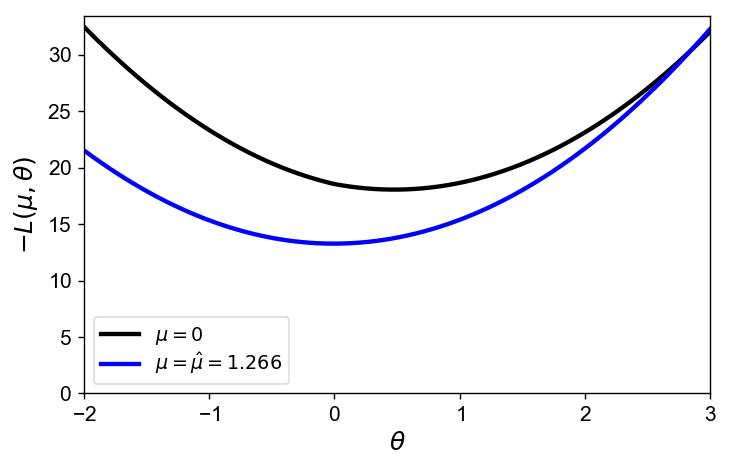

In [18]:
mus = vals[:,0]
thetas = vals[:,1]
nlls = vals[:,2]
# Select the slice with the smallest value of mu (should be 0 or close to it)
x = (mus == mus.min()) 
zero_nlls = nlls[x]
zero_thetas = thetas[x]

x = (mus == mus[np.abs(mus-mu_hat).argmin()]) # mu values that are closest to the mu_hat from above
best_nlls = nlls[x]
best_thetas = thetas[x]

fig,ax = plt.subplots()
ax.plot(zero_thetas,zero_nlls,label=r"$\mu=0$",color="k",lw=2.5)
ax.plot(best_thetas,best_nlls,label=r"$\mu=\hat{{\mu}}={:.3f}$".format(mu_hat),color="b",lw=2.5)

ax.set_ylim(0.,ax.get_ylim()[1])
ax.set_ylabel(r"$-L(\mu,\theta)$")
ax.set_xlabel(r"$\theta$")
ax.legend()
fig.savefig("plots/likelihood_vs_theta.pdf")



Let's define the LHC profiled test statistic $q_\mu$ as
$$
q_\mu = q(\mu) = -2\ln\frac{\mathcal{L}(\mu,\hat{\theta}_\mu)}{\mathcal{L}(\hat{\mu},\hat{\theta})}
$$
where $\hat{\theta}_\mu$ is the $\theta$ that maximizes $\mathcal{L}$ for a particular $\mu$. The pair $\hat{\mu}$ and $\hat{\theta}$ are the ones that globally maximize the likelihood. Thus, the denominator is a single number -- the global extremum of the 2-dimensional likelihood scan. The numerator is a 1-dimensional function which gives the maximum likelihood as a function of $\mu$. We have "profiled out" the nuisance parameter $\theta$.
Bear in mind the additional minus sign gymnastics we must do when switching between log likelihood and negative log likelihood:
$$
q_\mu = 2\left[\mathrm{NLL}(\mu,\hat{\theta}_\mu) - \mathrm{NLL}(\hat{\mu},\hat{\theta})\right]
$$
Or,
$$
q_\mu = 2\left[\mathrm{(NLL~values~along~red~curve~from~2D~scan)}-\mathrm{(NLL~value~at~the~x~from~2D~scan)}\right]
$$

Given this curve, we can identify the significance of the the data from one point. That is, how statistically significant would it be if just the background fluctuated to look like background+signal:
$$
\sigma_\text{obs} = \sqrt{q_0}
$$
And more generally, we can compute 1$\sigma$, 2$\sigma$, 3$\sigma$, etc. confidence bands on the fitted value of $\hat\mu$ by drawing lines at $q_\mu=1,4,9,...$ . Why these values? We turn to a normal distribution with pdf

$$
f(x|\mu,\sigma)=\frac{1}{\sqrt{2\pi\sigma^2}}e^{-\frac{(x-\mu)^2}{2\sigma^2}}
$$
Identifying this as a likelihood pdf and ignoring all constant/offset terms independent of $\sigma$ and $\mu$, then 
$$
q_\mu = -2\ln(f) = 2\frac{(x-\mu)^2}{2\sigma^2}
$$
We want $x\rightarrow \mu+k\cdot\sigma$ and $k$ is 1,2,3,..., so
$$
q_\mu \rightarrow \frac{(k\sigma)^2}{\sigma^2}=k^2
$$


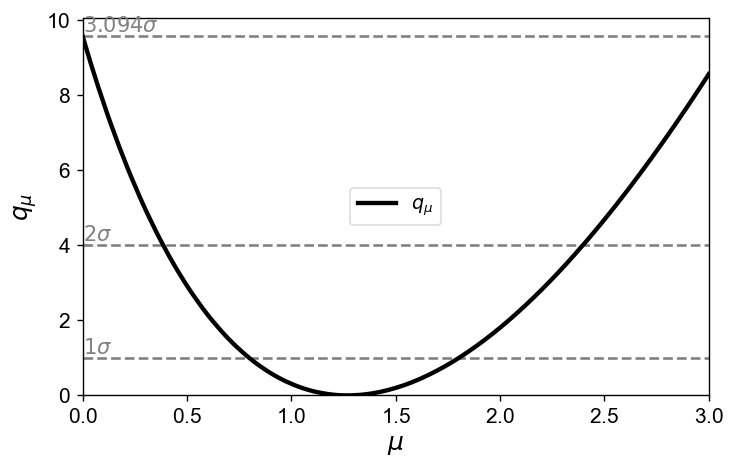

In [19]:
q_mu = 2*(all_best_nlls-best_nll)

q0 = q_mu[0]
significance = q0**0.5

fig,ax = plt.subplots()

for y,sigma in [
        [1,1],
        [4,2],
        [q0,"{:.3f}".format(significance)],
        ]:
    ax.plot([all_mus.min(),all_mus.max()],[y,y],color=(0.5,0.5,0.5),lw=1.5,linestyle="--")
    ax.text(all_mus.min(),y,r"${}\sigma$".format(sigma),color=(0.5,0.5,0.5),fontsize=12,horizontalalignment="left",verticalalignment="bottom")

ax.plot(all_mus,q_mu,label=r"$q_\mu$",color="k",lw=2.5)

ax.set_ylim(0.,ax.get_ylim()[1])
ax.set_ylabel(r"$q_\mu$")
ax.set_xlabel(r"$\mu$")
ax.legend()


fig.savefig("plots/qmu_vs_mu.pdf")

That's fine, but what if the whole implementation above is wrong? Let's check the HiggsCombine tool to make sure. 
1. Edit `include_syst` to `False` above and run all the cells again. The significance should be *3.25*.
2. Print out the "card" below and run with `combine -M Significance card.txt`.
3. You should get *3.25*!

Now turn on the systematic.
1. Edit `include_syst` to `True` above and run all the cells again. The significance should be *3.09*.
2. Print out the "card" below and run with `combine -M Significance card.txt`.
3. *WTF it gives 2.72*. FIXME sigh.

In [20]:

card = """
--------
imax 4
jmax 1
kmax *
bin bin1 bin2 bin3 bin4
observation {} {} {} {}
bin      bin1   bin1          bin2   bin2          bin3   bin3          bin4   bin4
process  sig    bg            sig    bg            sig    bg            sig    bg
process  0      1             0      1             0      1             0      1
rate     {:.1f} {:.1f}        {:.1f} {:.1f}        {:.1f} {:.1f}        {:.1f} {:.1f}
syst lnN -      {:.3f}/{:.3f} -      {:.3f}/{:.3f} -      {:.3f}/{:.3f} -      {:.3f}/{:.3f}
--------
""".format(
        v_data[0], v_data[1], v_data[2], v_data[3],
        v_sig[0], v_bg[0],
        v_sig[1], v_bg[1],
        v_sig[2], v_bg[2],
        v_sig[3], v_bg[3],
        v_bg_down[0]/v_bg[0], v_bg_up[0]/v_bg[0],
        v_bg_down[1]/v_bg[1], v_bg_up[1]/v_bg[1],
        v_bg_down[2]/v_bg[2], v_bg_up[2]/v_bg[2],
        v_bg_down[3]/v_bg[3], v_bg_up[3]/v_bg[3],
        )
print card


--------
imax 4
jmax 1
kmax *
bin bin1 bin2 bin3 bin4
observation 34 22 13 11
bin      bin1   bin1          bin2   bin2          bin3   bin3          bin4   bin4
process  sig    bg            sig    bg            sig    bg            sig    bg
process  0      1             0      1             0      1             0      1
rate     2.0 30.0        3.0 19.0        4.0 9.0        5.0 4.0
syst lnN -      1.000/1.000 -      0.974/1.026 -      0.889/1.111 -      0.750/1.250
--------



In [21]:
print v_bg
print v_bg_up
print interpolate_template(v_bg,v_bg_up,v_bg_down,f=0.)
print interpolate_template(v_bg,v_bg_up,v_bg_down,f=1.)
v_bg_up/v_bg

[30. 19.  9.  4.]
[30.  19.5 10.   5. ]
[30. 19.  9.  4.]
[30.  19.5 10.   5. ]


array([1.        , 1.02631579, 1.11111111, 1.25      ])

In [26]:
def get_info(
    v_data,
    v_bg,
    v_bg_up,
    v_bg_down,
    v_sig,
            ):
    # Make the values of mu, theta that we want to scan over
    all_mus = np.array([0.,1.])
    all_thetas = np.linspace(-2.,3.,51.)

    # Make a Gaussian(0,1) PDF to sample the theta values from
    norm = scipy.stats.norm(0,1)
    all_pthetas = norm.pdf(np.abs(all_thetas))

    # Precompute the ln(N!) terms for data in each bin
    n_logfac = np.array(map(log_factorial,v_data))

    # Where we will store triplets of (mu,theta,NLL)
    vals = []

    # Store a list of the theta giving highest log_likelihood for a given mu
    # as well as the negative log likelihood value using that theta
    all_best_mus = []
    all_best_thetas = []
    all_best_nlls = []
    for mu in all_mus:
        mu_thetas = [] # keep track of the thetas and nlls for this mu, then take the maximum for all_best_thetas later
        mu_nlls = [] #
        for theta,ptheta in zip(all_thetas,all_pthetas):

            bg = interpolate_template(v_bg,v_bg_up,v_bg_down,f=theta)
            sig = 1.0*v_sig
            n = 1.0*v_data
            k = mu*sig + bg

            log_likelihood = np.sum(n*np.log(k) - n_logfac - k + np.log(ptheta))
            nll = -log_likelihood

            vals.append([mu,theta,nll])
            mu_thetas.append(theta)
            mu_nlls.append(nll)

        mu_thetas = np.array(mu_thetas)
        mu_nlls = np.array(mu_nlls)
        all_best_thetas.append(mu_thetas[mu_nlls.argmin()])
        all_best_nlls.append(mu_nlls.min())
        all_best_mus.append(mu)

    all_best_mus = np.array(all_best_mus)
    all_best_thetas = np.array(all_best_thetas)
    all_best_nlls = np.array(all_best_nlls)

    # Drop nan likelihood values
    vals = np.array(vals)
    vals = vals[np.isfinite(vals[:,2])]
    return vals, all_best_mus, all_best_nlls



In [31]:
x = get_info(
    v_data,
    v_bg,
    v_bg_up,
    v_bg_down,
    v_sig,
)
print x[1]
print x[2]
qmu1 = 2*(x[2][1]-x[2][0])
print qmu1

[0. 1.]
[18.06019099 13.43046806]
-9.259445853784843


/Library/Python/2.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  # Remove the CWD from sys.path while we load stuff.


In [46]:
mu = 1.
f = np.random.normal(1000)
asimov = np.random.poisson(interpolate_template(v_bg,v_bg_up,v_bg_down,f=0.1)+mu*v_sig)
print v_data

[34 22 13 11]


In [81]:
def get_qmu(mu=0.,asimov=True,):
    f = np.random.normal(0,1,1)[0]
    if asimov:
        data = np.random.poisson(interpolate_template(v_bg,v_bg_up,v_bg_down,f=f)+mu*v_sig)
    else:
        data = v_data
    x = get_info(
        data,
        v_bg,
        v_bg_up,
        v_bg_down,
        v_sig,
    )
    qmu = 2*(x[2][1]-x[2][0])
    return qmu

In [84]:
from tqdm import tqdm

qmus1 = [get_qmu(1,asimov=True) for x in tqdm(range(10000))]
qmus0 = [get_qmu(0,asimov=True) for x in tqdm(range(10000))]
qmuobs = get_qmu(asimov=False)

  0%|          | 0/10000 [00:00<?, ?it/s]/Library/Python/2.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  # Remove the CWD from sys.path while we load stuff.
100%|██████████| 10000/10000 [00:33<00:00, 299.45it/s]


-9.259445853784843


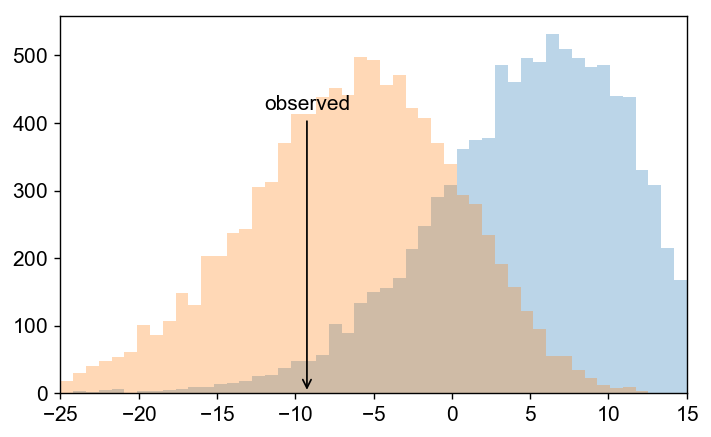

In [85]:
fig, ax_main = plt.subplots()

bins = np.linspace(-25.,15.,50)
ax_main.hist(qmus0,bins,alpha=0.3,histtype="stepfilled",label="b")
ax_main.hist(qmus1,bins,alpha=0.3,histtype="stepfilled",label="s+b")

ax_main.annotate(
        "observed", 
        xy=(qmuobs,0),
        xytext=(qmuobs,ax_main.get_ylim()[1]*0.75),
        arrowprops=dict(arrowstyle="->"),
        ha="center",
        fontsize=12
        )

print qmuobs

# ax_main.legend()
# ax_main.set_xticks([0,1,2,3])
# ax_main.set_xlabel("Njets",horizontalalignment="right",x=1.)
# _ = ax_main.set_ylabel("Events",horizontalalignment="right",y=1.)
